In [1]:
import pickle

import timm
import torch
from PIL import Image
from torch import nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel

from constants import (
    TRAIN_DATA_CSV,
    TEST_DATA_CSV,
    MULTIMODAL_MODEL_PATH,
    FINE_TUNED_FASTVIT_MODEL_PATH,
    FINE_TUNED_BERT_MODEL_PATH,
    TARGET_SCALER_PATH,
    IMAGES_PATH,
)
from core.src.utils.metrics import compute_metrics
from core.src.utils.plots import plot_loss_and_metrics, print_metrics_table

In [2]:
SLICE: int | None = None

df_train = pd.read_csv(TRAIN_DATA_CSV, dtype={"unique_id": str})[:SLICE]
df_test = pd.read_csv(TEST_DATA_CSV, dtype={"unique_id": str})[:SLICE]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.cuda.empty_cache()

with open(TARGET_SCALER_PATH, "rb") as f:
    target_scaler = pickle.load(f)

In [3]:
fastvit = timm.create_model("fastvit_t8.apple_in1k", pretrained=True, num_classes=0)

fastvit.head = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(fastvit.num_features, 1))

fastvit.load_state_dict(torch.load(FINE_TUNED_FASTVIT_MODEL_PATH))
fastvit.to(device)

data_config = timm.data.resolve_model_data_config(fastvit)
transforms = timm.data.create_transform(**data_config, is_training=False)


class FastViTEmbedding(nn.Module):
    def __init__(self, model):
        super(FastViTEmbedding, self).__init__()
        self.model = model
        self.pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        # Assuming the embeddings you want are just before the head.
        # This accesses the last layer before the regression head.
        x = self.model.forward_features(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return x


fastvit_model = FastViTEmbedding(fastvit).to(device)

In [4]:
tokenizer = AutoTokenizer.from_pretrained(
    "dumitrescustefan/bert-base-romanian-uncased-v1", do_lower_case=True, add_special_tokens=True, max_length=512, padding=True, truncation=True
)
bert_model = AutoModel.from_pretrained("dumitrescustefan/bert-base-romanian-uncased-v1")
bert_model.to(device)


class BERTRegressor(nn.Module):
    def __init__(self):
        super(BERTRegressor, self).__init__()
        self.bert = bert_model
        self.fc = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask)
        outputs = outputs[1]  # Use the output of the [CLS] token
        return outputs


bert_model = BERTRegressor().to(device)

bert_model.load_state_dict(torch.load(FINE_TUNED_BERT_MODEL_PATH))

<All keys matched successfully>

In [5]:
train_images = df_train["unique_id"].values
train_images = [IMAGES_PATH / f"{path}.png" for path in train_images]

test_images = df_test["unique_id"].values
test_images = [IMAGES_PATH / f"{path}.png" for path in test_images]

train_encodings = tokenizer(df_train["input"].tolist(), padding=True, truncation=True, max_length=512)
test_encodings = tokenizer(df_test["input"].tolist(), padding=True, truncation=True, max_length=512)

STRUCTURED_COLUMNS = [
    "km",
    "putere",
    "capacitate cilindrica",
    "anul producției",
    "marca",
    "model",
    "combustibil",
    "tip caroserie",
    "firma",
    "is_automatic",
]

train_structured_data = df_train[STRUCTURED_COLUMNS].to_numpy()
test_structured_data = df_test[STRUCTURED_COLUMNS].to_numpy()

train_targets = df_train["price_std"].to_numpy()
test_targets = df_test["price_std"].to_numpy()

print(f"Train images: {len(train_images)}")
print(f"Train encodings: {len(train_encodings['input_ids'])}")
print(f"Train structured data: {train_structured_data.shape}")
print(f"Train targets: {train_targets.shape}")

print(f"Test images: {len(test_images)}")
print(f"Test encodings: {len(test_encodings['input_ids'])}")
print(f"Test structured data: {test_structured_data.shape}")
print(f"Test targets: {test_targets.shape}")

Train images: 25422
Train encodings: 25422
Train structured data: (25422, 10)
Train targets: (25422,)
Test images: 6356
Test encodings: 6356
Test structured data: (6356, 10)
Test targets: (6356,)


In [6]:
class MultimodalDataset(Dataset):
    def __init__(self, images_paths, encodings, structured_data, targets):
        self.images_paths = images_paths
        self.encodings = encodings
        self.structured_data = structured_data
        self.targets = targets

    def __len__(self):
        return len(self.images_paths)

    def __getitem__(self, idx):
        image = Image.open(self.images_paths[idx])
        image = transforms(image)
        input_ids = torch.tensor(self.encodings["input_ids"][idx])
        attention_mask = torch.tensor(self.encodings["attention_mask"][idx])
        structured_data = torch.tensor(self.structured_data[idx]).float()
        target = torch.tensor(self.targets[idx]).float()

        return image, input_ids, attention_mask, structured_data, target

In [7]:
BATCH_SIZE = 4

train_dataset = MultimodalDataset(train_images, train_encodings, train_structured_data, train_targets)
test_dataset = MultimodalDataset(test_images, test_encodings, test_structured_data, test_targets)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
class MultiModalModel(nn.Module):
    def __init__(self, fastvit_model, bert_model):
        super(MultiModalModel, self).__init__()
        self.fastvit_model = fastvit_model
        self.bert_model = bert_model
        self.fc = nn.Linear(768 + 768 + 10, 1)
        # self.dropout = nn.Dropout(0.2)

    def forward(self, image, input_ids, attention_mask, structured_data):
        fastvit_embedding = self.fastvit_model(image)
        bert_embedding = self.bert_model(input_ids, attention_mask)
        x = torch.cat([fastvit_embedding, bert_embedding, structured_data], dim=1)
        x = self.fc(x)
        return x

In [9]:
multimodal_model = MultiModalModel(fastvit_model, bert_model).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(multimodal_model.parameters(), lr=0.00001)

history = {"train_loss": [], "test_loss": []}
metrics_history = {"train_mae": [], "test_mae": [], "train_rmse": [], "test_rmse": [], "train_r2": [], "test_r2": [], "train_mse": [], "test_mse": []}

multimodal_model

MultiModalModel(
  (fastvit_model): FastViTEmbedding(
    (model): FastVit(
      (stem): Sequential(
        (0): MobileOneBlock(
          (se): Identity()
          (conv_kxk): ModuleList(
            (0): ConvNormAct(
              (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
              (bn): BatchNormAct2d(
                48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
                (drop): Identity()
                (act): Identity()
              )
            )
          )
          (conv_scale): ConvNormAct(
            (conv): Conv2d(3, 48, kernel_size=(1, 1), stride=(2, 2), bias=False)
            (bn): BatchNormAct2d(
              48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Identity()
            )
          )
          (act): GELU(approximate='none')
        )
        (1): MobileOneBlock(
          (se): Identity()
          (conv_k

In [10]:
def print_model_statuses():
    print(f"Core FastViT model: {multimodal_model.fastvit_model.model.training}")
    print(f"Core BERT model: {multimodal_model.bert_model.bert.training}")

    print(f"FastVitEmbedding model: {multimodal_model.fastvit_model.training}")
    print(f"BERTEmbedding model: {multimodal_model.bert_model.training}")

    print(f"Multimodal model: {multimodal_model.training}")

In [11]:
def train(EPOCHS=100):
    best_val_loss = float("inf")
    multimodal_model.train()
    for epoch in range(EPOCHS):
        multimodal_model.train()
        # print_model_statuses()
        train_losses = []
        all_train_predictions = []
        all_train_ground_truths = []

        for batch in tqdm(train_loader):
            images, input_ids, attention_mask, structured_data, targets = [b.to(device) for b in batch]
            targets = targets.view(-1, 1)

            outputs = multimodal_model(images, input_ids, attention_mask, structured_data)

            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

            unnorm_outputs = target_scaler.inverse_transform(outputs.cpu().detach().numpy())
            unnorm_targets = target_scaler.inverse_transform(targets.cpu().detach().numpy())

            all_train_predictions.extend(unnorm_outputs)
            all_train_ground_truths.extend(unnorm_targets)

        train_metrics = compute_metrics(all_train_predictions, all_train_ground_truths)
        metrics_history["train_mae"].append(train_metrics["MAE"])
        metrics_history["train_mse"].append(train_metrics["MSE"])
        metrics_history["train_rmse"].append(train_metrics["RMSE"])
        metrics_history["train_r2"].append(train_metrics["R2"])

        avg_train_loss = np.sum(train_losses) / len(train_loader)
        history["train_loss"].append(avg_train_loss)
        print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss}")
        print(f"Epoch {epoch + 1}, Train Metrics: {train_metrics}")

        multimodal_model.eval()
        # print_model_statuses()
        with torch.no_grad():
            validation_losses = []
            all_test_predictions = []
            all_test_ground_truths = []
            for batch in test_loader:
                images, input_ids, attention_mask, structured_data, targets = [b.to(device) for b in batch]
                targets = targets.view(-1, 1)

                outputs = multimodal_model(images, input_ids, attention_mask, structured_data)
                loss = criterion(outputs, targets)
                validation_losses.append(loss.item())

                unnorm_outputs = target_scaler.inverse_transform(outputs.cpu().detach().numpy())
                unnorm_targets = target_scaler.inverse_transform(targets.cpu().detach().numpy())

                all_test_predictions.extend(unnorm_outputs)
                all_test_ground_truths.extend(unnorm_targets)

            avg_val_loss = np.sum(validation_losses) / len(test_loader)
            history["test_loss"].append(avg_val_loss)

            test_metrics = compute_metrics(all_test_predictions, all_test_ground_truths)
            metrics_history["test_mae"].append(test_metrics["MAE"])
            metrics_history["test_mse"].append(test_metrics["MSE"])
            metrics_history["test_rmse"].append(test_metrics["RMSE"])
            metrics_history["test_r2"].append(test_metrics["R2"])

            print(f"Epoch {epoch + 1}, Validation Loss: {avg_val_loss}")
            print(f"Epoch {epoch + 1}, Test Metrics: {test_metrics}")

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(multimodal_model.state_dict(), MULTIMODAL_MODEL_PATH)
                print(f"Epoch {epoch + 1}: New best test loss: {best_val_loss}")

In [12]:
train(10)

100%|██████████| 6356/6356 [25:16<00:00,  4.19it/s]


Epoch 1, Train Loss: 0.1787009118045169
Epoch 1, Train Metrics: {'MAE': 2705.3599, 'MSE': 14192221.0, 'RMSE': 3767.2563, 'R2': 0.8205121805374411}


100%|██████████| 1589/1589 [02:31<00:00, 10.52it/s]


Epoch 1, Validation Loss: 0.1446963828124453
Epoch 1, Test Metrics: {'MAE': 2453.0347, 'MSE': 11490801.0, 'RMSE': 3389.8083, 'R2': 0.8548506229919905}
Epoch 1: New best test loss: 0.1446963828124453


100%|██████████| 6356/6356 [25:18<00:00,  4.19it/s]


Epoch 2, Train Loss: 0.11123260514397074
Epoch 2, Train Metrics: {'MAE': 2143.4263, 'MSE': 8833958.0, 'RMSE': 2972.1975, 'R2': 0.8882776817662236}


100%|██████████| 1589/1589 [02:29<00:00, 10.60it/s]


Epoch 2, Validation Loss: 0.11274839452515627
Epoch 2, Test Metrics: {'MAE': 2097.2485, 'MSE': 8953709.0, 'RMSE': 2992.275, 'R2': 0.8868986323738544}
Epoch 2: New best test loss: 0.11274839452515627


100%|██████████| 6356/6356 [25:09<00:00,  4.21it/s]


Epoch 3, Train Loss: 0.077804065174688
Epoch 3, Train Metrics: {'MAE': 1805.5997, 'MSE': 6178931.0, 'RMSE': 2485.7456, 'R2': 0.9218555772183714}


100%|██████████| 1589/1589 [02:30<00:00, 10.54it/s]


Epoch 3, Validation Loss: 0.10988900616002792
Epoch 3, Test Metrics: {'MAE': 2069.2566, 'MSE': 8726636.0, 'RMSE': 2954.0881, 'R2': 0.8897669698773951}
Epoch 3: New best test loss: 0.10988900616002792


100%|██████████| 6356/6356 [25:15<00:00,  4.19it/s]


Epoch 4, Train Loss: 0.05883899204087995
Epoch 4, Train Metrics: {'MAE': 1585.8285, 'MSE': 4672948.5, 'RMSE': 2161.7004, 'R2': 0.9409016164915255}


100%|██████████| 1589/1589 [02:29<00:00, 10.61it/s]


Epoch 4, Validation Loss: 0.10795938910168723
Epoch 4, Test Metrics: {'MAE': 2046.788, 'MSE': 8573400.0, 'RMSE': 2928.0369, 'R2': 0.8917026250378399}
Epoch 4: New best test loss: 0.10795938910168723


100%|██████████| 6356/6356 [25:05<00:00,  4.22it/s]


Epoch 5, Train Loss: 0.04464781086279702
Epoch 5, Train Metrics: {'MAE': 1400.1006, 'MSE': 3545113.5, 'RMSE': 1882.8472, 'R2': 0.9551652512881766}


100%|██████████| 1589/1589 [02:27<00:00, 10.77it/s]


Epoch 5, Validation Loss: 0.10505870236579125
Epoch 5, Test Metrics: {'MAE': 2000.6256, 'MSE': 8343047.0, 'RMSE': 2888.4333, 'R2': 0.8946123926003461}
Epoch 5: New best test loss: 0.10505870236579125


100%|██████████| 6356/6356 [24:52<00:00,  4.26it/s]


Epoch 6, Train Loss: 0.03637622910282814
Epoch 6, Train Metrics: {'MAE': 1273.531, 'MSE': 2888942.0, 'RMSE': 1699.6888, 'R2': 0.9634637943527935}


100%|██████████| 1589/1589 [02:28<00:00, 10.69it/s]


Epoch 6, Validation Loss: 0.09715052732274398
Epoch 6, Test Metrics: {'MAE': 1910.2772, 'MSE': 7715032.5, 'RMSE': 2777.5947, 'R2': 0.9025453302954929}
Epoch 6: New best test loss: 0.09715052732274398


100%|██████████| 6356/6356 [24:50<00:00,  4.26it/s]


Epoch 7, Train Loss: 0.030362380380726813
Epoch 7, Train Metrics: {'MAE': 1169.498, 'MSE': 2411082.2, 'RMSE': 1552.766, 'R2': 0.9695072454266738}


100%|██████████| 1589/1589 [02:28<00:00, 10.73it/s]


Epoch 7, Validation Loss: 0.0931744166166194
Epoch 7, Test Metrics: {'MAE': 1891.3678, 'MSE': 7399277.0, 'RMSE': 2720.1611, 'R2': 0.906533888610799}
Epoch 7: New best test loss: 0.0931744166166194


100%|██████████| 6356/6356 [24:50<00:00,  4.26it/s]


Epoch 8, Train Loss: 0.02618214306518377
Epoch 8, Train Metrics: {'MAE': 1093.3003, 'MSE': 2079327.1, 'RMSE': 1441.9872, 'R2': 0.9737029269038331}


100%|██████████| 1589/1589 [02:28<00:00, 10.67it/s]


Epoch 8, Validation Loss: 0.0888856114875912
Epoch 8, Test Metrics: {'MAE': 1826.8278, 'MSE': 7058690.5, 'RMSE': 2656.8196, 'R2': 0.9108361198579211}
Epoch 8: New best test loss: 0.0888856114875912


100%|██████████| 6356/6356 [24:59<00:00,  4.24it/s]


Epoch 9, Train Loss: 0.022983473257302142
Epoch 9, Train Metrics: {'MAE': 1019.269, 'MSE': 1825279.1, 'RMSE': 1351.0289, 'R2': 0.9769158487740324}


100%|██████████| 1589/1589 [02:28<00:00, 10.73it/s]


Epoch 9, Validation Loss: 0.09254670968716477
Epoch 9, Test Metrics: {'MAE': 1856.2245, 'MSE': 7349429.0, 'RMSE': 2710.983, 'R2': 0.9071635589415923}


100%|██████████| 6356/6356 [24:51<00:00,  4.26it/s]


Epoch 10, Train Loss: 0.020410294507666224
Epoch 10, Train Metrics: {'MAE': 968.9142, 'MSE': 1620947.5, 'RMSE': 1273.1643, 'R2': 0.9795000151895745}


100%|██████████| 1589/1589 [02:29<00:00, 10.63it/s]

Epoch 10, Validation Loss: 0.08980636425691295
Epoch 10, Test Metrics: {'MAE': 1841.7902, 'MSE': 7131810.0, 'RMSE': 2670.545, 'R2': 0.9099124838942916}


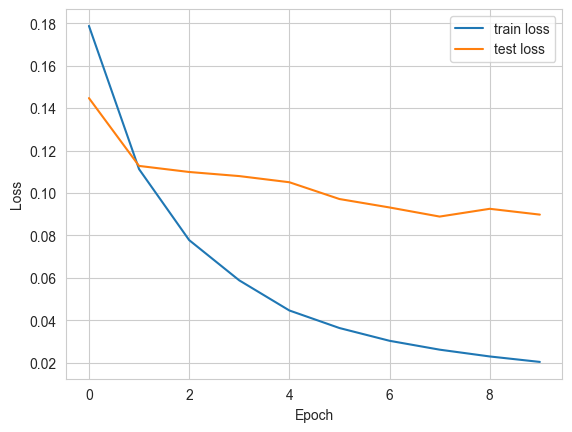

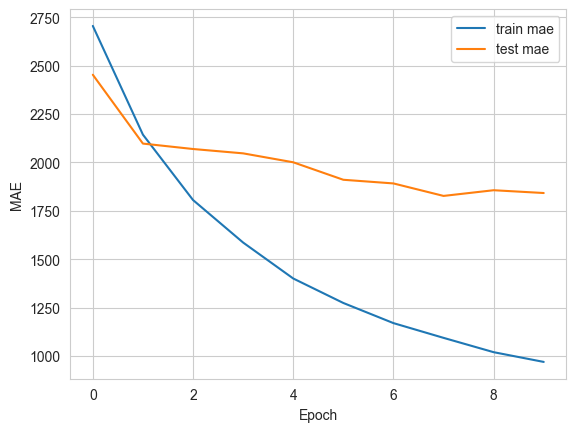

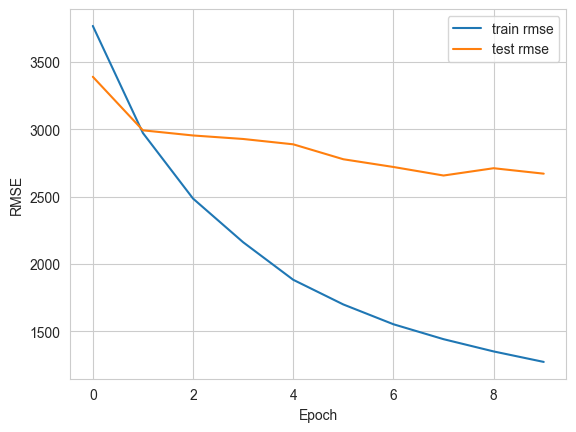

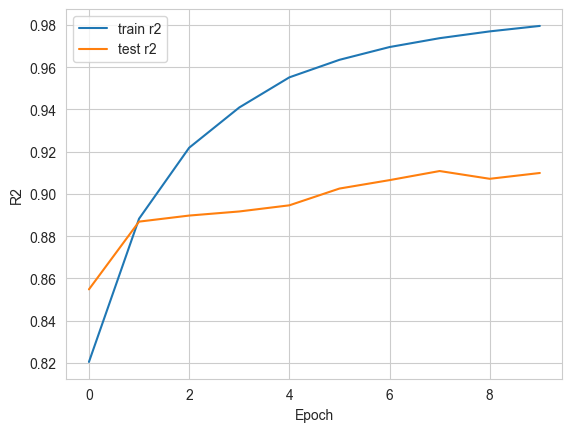

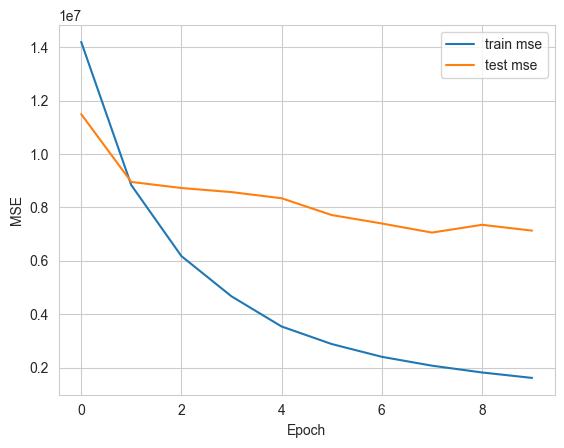

Train Metrics
+---------+---------+---------+--------+-------------+
|   Epoch |     MAE |    RMSE |     R2 |         MSE |
+=========+=========+=========+========+=============+
|       9 | 968.914 | 1273.16 | 0.9795 | 1.62095e+06 |
+---------+---------+---------+--------+-------------+

Test Metrics
+---------+---------+---------+---------+-------------+
|   Epoch |     MAE |    RMSE |      R2 |         MSE |
+=========+=========+=========+=========+=============+
|       9 | 1841.79 | 2670.54 | 0.90991 | 7.13181e+06 |
+---------+---------+---------+---------+-------------+


In [13]:
plot_loss_and_metrics(history, metrics_history, SLICE_START=0)
print_metrics_table(metrics_history)